Imports

In [95]:
import pickle
import gzip
import numpy as np
#import os
#from PIL import Image as im
import cv2
#import pandas as pd
import matplotlib.pyplot as plt
#import torchdata as td
#from torchmetrics.functional import jaccard_index
#from tensorflow.keras.utils import to_categorical
from PIL import Image as im
from skimage.measure import label, regionprops
#from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras

#from keras import backend as K
from tensorflow.keras import layers
from sklearn.model_selection import KFold

In [96]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

## Box U-Net

In [97]:
def double_conv_block_box(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   return x

def downsample_block_box(x, n_filters):
   f = double_conv_block_box(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   #p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block_box(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 2, 2, padding="valid")(x)
   x = layers.concatenate([x, conv_features])
   #x = layers.Dropout(0.3)(x)
   x = double_conv_block_box(x, n_filters)
   return x

In [98]:
def get_model_box(img_size):
    inputs = layers.Input(shape=img_size+(1,))
    
    f1, p1 = downsample_block_box(inputs, 16)
    f2, p2 = downsample_block_box(p1, 32)
    f3, p3 = downsample_block_box(p2, 64)
    #f4, p4 = downsample_block(p3, 256)
    
    #bottleneck = double_conv_block(p4, 512)
    bottleneck = double_conv_block_box(p3, 128)
    
    #u6 = upsample_block(bottleneck, f4, 256)
    u7 = upsample_block_box(bottleneck, f3, 64)
    u8 = upsample_block_box(u7, f2, 32)
    u9 = upsample_block_box(u8, f1, 16)

    outputs = layers.Conv2D(1, 1, padding="valid", activation = "sigmoid")(u9)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net-Box")
    
    return unet_model

## Data Preparation

In [99]:
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")

In [199]:
amateur = 0
expert = 0
for i in range(len(train_data)):
    if train_data[i]["dataset"] == "amateur":
        amateur += 1
    else:
        expert += 1

print("amateur: ", amateur)
print("expert: ", expert)

amateur:  46
expert:  19


### Box
Videos have different lengths so consider individual images - each with the same box as label - and increase batch size

In [100]:
# concatenate all video frames into one image
x_train_box= []
y_train_box = []
for dic in train_data:
    for i in range(dic["video"].shape[2]):
        x_train_box.append(cv2.resize(dic["video"][:,:,i], dsize=(256, 256)))
        y_train_box.append(cv2.resize(255 * dic["box"].astype(np.ubyte), dsize=(256, 256)))

x_train_box = np.expand_dims(np.array(x_train_box, dtype=np.single), 3)
y_train_box = np.expand_dims(np.array(y_train_box, dtype=np.single), 3)

9869


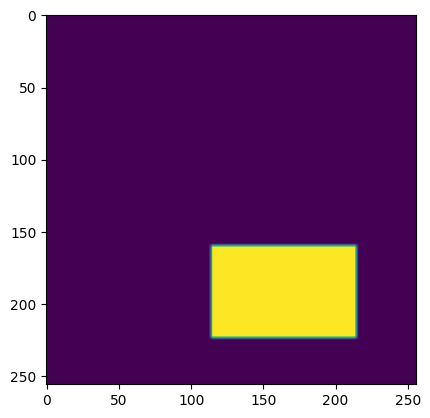

In [101]:
print(len(y_train_box))
plt.imshow(y_train_box[0][:,:,0])
plt.show()


## Training and prediction

### Fix seed

In [102]:
# fix seed
seed = 1
np.random.seed(seed)

### Box

In [104]:
EPOCHS = 8
BATCH_SIZE = 50
fold_no = 0
print(len(x_train_box))
print(len(y_train_box))
for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(y_train_box):
    
    fold_no += 1
    print('------------------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    print('------------------------------------------------------------------------------------')
    
    keras.backend.clear_session()
    model = get_model_box((256, 256))
    model.summary()
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        #loss=keras.losses.CategoricalCrossentropy(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    model.fit(
        x_train_box[train_idx],
        y_train_box[train_idx],
        validation_data=(x_train_box[test_idx], y_train_box[test_idx]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=2
    )
    
    #scores = model.evaluate(samples[test_idx], labels[test_idx], verbose=0)
    #f1 = f1_score(np.argmax(labels[test_idx], axis=1), np.argmax(model.predict(samples[test_idx]), axis=1), average='micro')
    #print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; f1_score of {f1}')
    break

9869
9869
------------------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------------------
Model: "U-Net-Box"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                    

Save model

In [105]:
model.save("model_box.h5")

Load model if already trained

In [ ]:
# Load model_box.h5
# model = tf.keras.models.load_model("model_box.h5")

In [123]:
pred = model.predict(x_train_box[test_idx])
x_train_box[test_idx].shape

62/62 [==============================] - 54s 870ms/step


(1974, 256, 256, 1)

Get The video lenghts

In [174]:
video_lengths = [dic["video"].shape[2] for dic in train_data]
# make video_lengths entries sum up preceding entries
video_lengths = np.cumsum(video_lengths) - 1
video_lengths

array([ 333,  510,  705,  886, 1097, 1306, 1435, 1614, 1782, 1933, 2046,
       2260, 2411, 2577, 2787, 2905, 3082, 3253, 3511, 3684, 3874, 3983,
       4189, 4385, 4499, 4675, 4852, 5042, 5243, 5421, 5549, 5764, 5938,
       6159, 6309, 6488, 6629, 6769, 6953, 7112, 7266, 7438, 7593, 7809,
       7971, 8169, 8245, 8328, 8382, 8472, 8566, 8682, 8753, 8838, 8908,
       8987, 9062, 9157, 9258, 9371, 9530, 9593, 9677, 9803, 9868])

In [183]:
def get_video_frame(indexes):
    videos = []
    frames = []
    for index in indexes:
        for i, frame in enumerate(video_lengths):
            if index <= frame:
                videos.append(i)
                if(i == 0):
                    frames.append(index)
                else:
                    frames.append(index - video_lengths[i-1] - 1)
                break
    return videos, frames


In [ ]:
videos, frames = get_video_frame(test_idx)
for i in range(50):
    print("test idx: ", test_idx[i], "video: ", videos[i], "frame: ", frames[i])

In [ ]:
TH = 0.999

for i in range(10):
    gt =train_data[videos[i]]["video"][:,:,frames[i]]
    plt.imshow(gt)
    plt.show()
    first_frame = 255 * pred[i,:,:,0]
    first_frame = first_frame > (255 * TH)
    plt.imshow(first_frame)
    plt.show()

# test_frame = 255 * pred[0,:,:,0]
# test_frame = test_frame > (255 * TH)
# print(test_frame)
# plt.imshow(test_frame)
# plt.show()

# pp = cv2.resize(255 * pred[0,:,:], dsize=train_data[0]["video"][0].shape[::-1])
# pp = pp > (255 * TH)    
# pred_img = im.fromarray(pp)
# im
# plt.imshow(y_train_box[test_idx][0][:,:,0])
# plt.show()
# plt.imshow(pred[0][:,:,0])
# plt.show()

In [ ]:
# pred = model.predict(x_train[test_idx])
# pred = np.squeeze(pred)

# TH = 0.999
# NB_OF_AREAS = 4
# intersection = 0
# union = 0
# fehlt = 0
# for i in range(39):
#     idx = test_idx[i]
#     ff = train_data[idx//3]["frames"][idx%3]
#     gt = train_data[idx//3]["label"][:,:,ff]
#     gt_img = im.fromarray(gt)
    
#     pp = cv2.resize(255 * pred[i,:,:], dsize=gt.shape[::-1])
#     pp = pp > (255 * TH)    
#     pred_img = im.fromarray(pp)
    
#     lab = label(pp)
#     rps = regionprops(lab)
#     area_idx = np.argsort([r.area for r in rps])[::-1]
#     new_pp = np.zeros_like(pp)
#     for j in area_idx[:NB_OF_AREAS]:
#         new_pp[tuple(rps[j].coords.T)] = True
#     new_pred_img = im.fromarray(new_pp)
    
#     fehlt += np.count_nonzero(np.logical_and(gt, np.logical_not(new_pp)))
#     intersection += np.count_nonzero(np.logical_and(gt, new_pp))
#     union += np.count_nonzero(np.logical_or(gt, new_pp))
    
# print(fehlt)
# print("score:")
# print(intersection / union)

# #pred = im.fromarray((np.squeeze(model.predict(x_train[16:17]))>0.8))
# #gt = im.fromarray(cv2.resize(255 * train_data[5]["label"][:,:,51].astype(np.ubyte), dsize=(360, 360)))

In [ ]:
pred = model.predict(x_train_box[test_idx])
pred = np.squeeze(pred)

TH = 0.999

NB_OF_AREAS = 4
intersection = 0
union = 0
fehlt = 0
for i in range(39):
    idx = test_idx[i]
    ff = train_data[idx//3]["frames"][idx%3]
    gt = train_data[idx//3]["label"][:,:,ff]
    gt_img = im.fromarray(gt)
    
    pp = cv2.resize(255 * pred[i,:,:], dsize=gt.shape[::-1])
    pp = pp > (255 * TH)    
    pred_img = im.fromarray(pp)
    
    lab = label(pp)
    rps = regionprops(lab)
    area_idx = np.argsort([r.area for r in rps])[::-1]
    new_pp = np.zeros_like(pp)
    for j in area_idx[:NB_OF_AREAS]:
        new_pp[tuple(rps[j].coords.T)] = True
    new_pred_img = im.fromarray(new_pp)
    
    fehlt += np.count_nonzero(np.logical_and(gt, np.logical_not(new_pp)))
    intersection += np.count_nonzero(np.logical_and(gt, new_pp))
    union += np.count_nonzero(np.logical_or(gt, new_pp))
    
print(fehlt)
print("score:")
print(intersection / union)

# pred = im.fromarray((np.squeeze(model.predict(x_train[16:17]))>0.8))
# gt = im.fromarray(cv2.resize(255 * train_data[5]["label"][:,:,51].astype(np.ubyte), dsize=(360, 360)))